# DAB Technical Interview Case Challenge #1 – Eli Ordonez

In this case challenge, I will be posing as an AI Engineer working for the Ministry of Education. The Ministry of Education is currently developing a resource Secondary School Mathematics Head-of-Deaprtments can use to flag students at risk of failing their Mathematics O-Level exam.

I have been given data on the previous year's country-wide O-Level mathematics results, alongside details about each participant's background, and am expected to design an end-to-end machine learning pipeline that can predict whether a student will *fail* their O-Level Mathematics exam based on their environmental factors.

The dataset contains the following columns:

1. **student_id**: Unique ID for each student
2. **number_of_siblings**: Number of siblings
3. **direct_admission**: Mode of entering the school
4. **CCA**: Enrolled CCA
5. **learning_style**: Primary learning style
6. **tuition**: Indication of whether the student has a tuition
7. **n_male**: Number of male classmates
8. **n_female**: Number of female classmates
9. **gender**: Gender type
10. **age**: Age of the student
11. **hours_per_week**: Number of hours student studies per week
12. **attendance_rate**: Attendance rate of the student [It is unclear what the time frame is; whether it is for the last year or last year before completing O-Levels, etc] (%)
13. **sleep_time**: Daily sleeping time (hour:minutes)
14. **wake_time**: Daily waking up time (hour:minutes)
15. **mode_of_transport**: Mode of transport to school
16. **bag_color**: Colour of student’s bag
17. **final_test**: Student’s O-level mathematics examination score.

While the brief stated that 'final_test' was the dataset's y-variable, because my problem statement concerns those who are simply at risk of failing, I endeavour to engineer a new column 'failed' based on 'final_test', which marks students who failed the O-Level examination.

## Part 1: Loading the Data & First Impressions

In [727]:
# For handling data using SQLite
import sqlite3
from prettytable import from_db_cursor

# For handling data using pandas
import pandas as pd
import numpy as np

# For data visualisation
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# For modelling
from sklearn.ensemble import RandomForestClassifier

# For inter-feature analysis
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from scipy.stats import chi2_contingency

conn = sqlite3.connect('/Users/elimatthewordonez/Dropbox/OTHERS/Data Analytics Training/Personal Projects/GA Technical Assessment Simulation/data/score.db')
cursor = conn.cursor()

In [435]:
query = "SELECT * FROM score LIMIT 10"
df = pd.read_sql_query(query, conn)
df

,index,number_of_siblings,direct_admission,CCA,learning_style,student_id,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport,bag_color
0,0,0,Yes,Sports,Visual,ACN2BE,Female,No,69.0,14.0,2.0,16.0,10.0,91.0,22:00,6:00,private transport,yellow
1,1,2,No,Sports,Auditory,FGXIIZ,Female,No,47.0,4.0,19.0,16.0,7.0,94.0,22:30,6:30,private transport,green
2,2,0,Yes,None,Visual,B9AI9F,Male,No,85.0,14.0,2.0,15.0,8.0,92.0,22:30,6:30,private transport,white
3,3,1,No,Clubs,Auditory,FEVM1T,Female,Yes,64.0,2.0,20.0,15.0,18.0,NaN,21:00,5:00,public transport,yellow
4,4,0,No,Sports,Auditory,AXZN2E,Male,No,66.0,24.0,3.0,16.0,7.0,95.0,21:30,5:30,public transport,yellow
5,5,0,No,Arts,Visual,BA6R14,Female,No,57.0,9.0,12.0,15.0,11.0,96.0,22:30,6:30,private transport,red
6,6,2,Yes,None,Visual,D5WGTI,Male,No,69.0,12.0,3.0,16.0,15.0,93.0,21:30,5:30,public transport,green
7,7,0,No,Sports,Visual,HTP8CW,Male,No,76.0,20.0,2.0,15.0,3.0,97.0,21:00,5:00,public transport,green
8,8,0,No,Arts,Auditory,U3YRTC,Male,No,57.0,20.0,7.0,15.0,15.0,98.0,22:00,6:00,private transport,red
9,9,2,No,Arts,Auditory,3MOMA6,Male,Yes,60.0,13.0,9.0,16.0,16.0,NaN,22:30,6:30,private transport,green


In [436]:
# Before we go any further, I want to convert the .db data to a .csv format so I can use pandas to conduct more complex manipulation of the data
query = "SELECT * FROM score"
df = pd.read_sql_query(query, conn)
df.to_csv('score.csv',index=False)

In [437]:
# Now let's import the data from the .csv file
score = pd.read_csv('/Users/elimatthewordonez/Dropbox/OTHERS/Data Analytics Training/Personal Projects/GA Technical Assessment Simulation/score.csv')
score.head()

,index,number_of_siblings,direct_admission,CCA,learning_style,student_id,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport,bag_color
0,0,0,Yes,Sports,Visual,ACN2BE,Female,No,69.0,14.0,2.0,16.0,10.0,91.0,22:00,6:00,private transport,yellow
1,1,2,No,Sports,Auditory,FGXIIZ,Female,No,47.0,4.0,19.0,16.0,7.0,94.0,22:30,6:30,private transport,green
2,2,0,Yes,NaN,Visual,B9AI9F,Male,No,85.0,14.0,2.0,15.0,8.0,92.0,22:30,6:30,private transport,white
3,3,1,No,Clubs,Auditory,FEVM1T,Female,Yes,64.0,2.0,20.0,15.0,18.0,NaN,21:00,5:00,public transport,yellow
4,4,0,No,Sports,Auditory,AXZN2E,Male,No,66.0,24.0,3.0,16.0,7.0,95.0,21:30,5:30,public transport,yellow


In [438]:
# How many rows & columns are there in the dataset?
score.shape

(15900, 18)

In [439]:
# Visually, I would like the columns to be rearranged according to groups of similar information categories
# 1. Admin/General: Index, Student_id, Gender, Age, Learning_style
# 2. School/Study Data: Attendance_rate, Hours_per_week, n_male, n_female
# 3. DSA/CCA: Direct_admission, CCA
# 4. Tuition: Tuition
# 5. Home Factors: Number_of_siblings, sleep_time, wake_time, mode_of_transport, bag_color
# final_test

new_order = ['index','student_id','gender','age','learning_style','attendance_rate','hours_per_week','n_male','n_female','direct_admission','CCA','tuition','number_of_siblings','sleep_time','wake_time','mode_of_transport','bag_color','final_test']
score = score[new_order]
score.head()

,index,student_id,gender,age,learning_style,attendance_rate,hours_per_week,n_male,n_female,direct_admission,CCA,tuition,number_of_siblings,sleep_time,wake_time,mode_of_transport,bag_color,final_test
0,0,ACN2BE,Female,16.0,Visual,91.0,10.0,14.0,2.0,Yes,Sports,No,0,22:00,6:00,private transport,yellow,69.0
1,1,FGXIIZ,Female,16.0,Auditory,94.0,7.0,4.0,19.0,No,Sports,No,2,22:30,6:30,private transport,green,47.0
2,2,B9AI9F,Male,15.0,Visual,92.0,8.0,14.0,2.0,Yes,NaN,No,0,22:30,6:30,private transport,white,85.0
3,3,FEVM1T,Female,15.0,Auditory,NaN,18.0,2.0,20.0,No,Clubs,Yes,1,21:00,5:00,public transport,yellow,64.0
4,4,AXZN2E,Male,16.0,Auditory,95.0,7.0,24.0,3.0,No,Sports,No,0,21:30,5:30,public transport,yellow,66.0


## Part 2: Data Cleaning & Engineering

In [441]:
# Let's see how much of the data is null
round(score.isnull().sum()/len(score)*100)

index                  0.0
student_id             0.0
gender                 0.0
age                    0.0
learning_style         0.0
attendance_rate        5.0
hours_per_week         0.0
n_male                 0.0
n_female               0.0
direct_admission       0.0
CCA                   24.0
tuition                0.0
number_of_siblings     0.0
sleep_time             0.0
wake_time              0.0
mode_of_transport      0.0
bag_color              0.0
final_test             3.0
dtype: float64

We can see that 3% of the data have null values under 'final_test'. Additionally, 5% of the data have null values under 'attendance_rate' and a staggering 24% of the data have null values under 'CCA'.

In the end, I find it useful to have 'final_test' data for the whole dataset, because I want to be able to evaluate my modelling process on the test data when I eventually get there. As a result, my gut feel is to drop the 3% of the data that do not have 'final_test'. I am okay doing so as the rows where 'final_test' is null constitute a small fraction of the dataset.

As for 'attendance_rate and 'CCA', I have to do a bit more investigation to understand how to address their null values.

### Addressing Duplicated Rows

In [444]:
# Are there any duplicated rows?
duplicates = score[score.duplicated(subset=['student_id'],keep='first')]
duplicates.sort_values('student_id')

,index,student_id,gender,age,learning_style,attendance_rate,hours_per_week,n_male,n_female,direct_admission,CCA,tuition,number_of_siblings,sleep_time,wake_time,mode_of_transport,bag_color,final_test
12290,12290,00811H,Female,15.0,Auditory,92.0,8.0,21.0,4.0,No,Clubs,Yes,0,23:00,7:00,walk,white,88.0
13541,13541,0195IO,Female,16.0,Visual,99.0,15.0,8.0,22.0,No,Arts,No,1,22:00,6:00,private transport,yellow,52.0
9172,9172,02RSAH,Female,15.0,Auditory,97.0,17.0,12.0,9.0,No,Clubs,Yes,0,22:00,6:00,private transport,green,64.0
9791,9791,0FC4RY,Female,15.0,Auditory,100.0,6.0,23.0,4.0,No,Arts,No,0,23:00,7:00,walk,yellow,68.0
6339,6339,0JUGAF,Female,16.0,Visual,94.0,10.0,18.0,2.0,Yes,NaN,No,0,23:00,7:00,walk,yellow,84.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4645,4645,ZR1W4F,Male,16.0,Visual,92.0,6.0,19.0,0.0,No,Arts,Yes,0,22:30,6:30,private transport,black,92.0
8036,8036,ZS4TCG,Female,15.0,Auditory,93.0,8.0,15.0,7.0,No,Arts,No,2,22:30,6:30,private transport,green,56.0
7511,7511,ZUGVXE,Female,16.0,Auditory,91.0,9.0,24.0,3.0,No,NaN,No,0,21:30,5:30,public transport,red,67.0
9953,9953,ZZICEC,Female,15.0,Auditory,93.0,12.0,11.0,13.0,No,Arts,Yes,1,22:00,6:00,private transport,blue,54.0


There are a total of 900 duplicates. These rows are duplicates across all columns except 'index'. Their indexes have already been identified in the subset above. Let's drop these rows.

In [446]:
# There are now 900 less rows after all duplicates have been removed. 
score = score.drop_duplicates(subset=['student_id'],keep='first')
score.shape

(15000, 18)

### Addressing Null Values

#### Dropping rows with null values under 'final_test'

In [449]:
# Let's review the null values in our dataset again
(score.isnull().sum()/len(score)*100).round(2)

index                  0.00
student_id             0.00
gender                 0.00
age                    0.00
learning_style         0.00
attendance_rate        4.89
hours_per_week         0.00
n_male                 0.00
n_female               0.00
direct_admission       0.00
CCA                   24.05
tuition                0.00
number_of_siblings     0.00
sleep_time             0.00
wake_time              0.00
mode_of_transport      0.00
bag_color              0.00
final_test             3.09
dtype: float64

In [450]:
# Let's drop all rows where 'final_test' is null
score = score.dropna(axis=0,subset=['final_test'])
# Now, we have 463 fewer rows.
score.shape

(14537, 18)

#### Dropping rows with null values under 'attendance_rate'

Upon further thinking, I realised that even if I dropped all rows where either 'attendance_rate' and 'final_test' were null, I would lose only 7.98% of the data. This is < 10% of the total data, and will not cause the data to skew dramatically. I have already dropped all rows where 'final_test' was null, so now I will drop all rows where 'attendance_rate' is null.

In [453]:
score = score.dropna(axis=0,subset=['attendance_rate'])
score.shape

(13824, 18)

#### Addressing null values under 'CCA' 

In [455]:
(score.isnull().sum()/len(score)*100).round()

index                  0.0
student_id             0.0
gender                 0.0
age                    0.0
learning_style         0.0
attendance_rate        0.0
hours_per_week         0.0
n_male                 0.0
n_female               0.0
direct_admission       0.0
CCA                   24.0
tuition                0.0
number_of_siblings     0.0
sleep_time             0.0
wake_time              0.0
mode_of_transport      0.0
bag_color              0.0
final_test             0.0
dtype: float64

In [456]:
# Now, let's look at the null values in 'CCA'
null_cca = score[score['CCA'].isnull()]
null_cca

,index,student_id,gender,age,learning_style,attendance_rate,hours_per_week,n_male,n_female,direct_admission,CCA,tuition,number_of_siblings,sleep_time,wake_time,mode_of_transport,bag_color,final_test
2,2,B9AI9F,Male,15.0,Visual,92.0,8.0,14.0,2.0,Yes,NaN,No,0,22:30,6:30,private transport,white,85.0
6,6,D5WGTI,Male,16.0,Visual,93.0,15.0,12.0,3.0,Yes,NaN,No,2,21:30,5:30,public transport,green,69.0
17,17,FALLVI,Female,15.0,Auditory,100.0,10.0,26.0,2.0,No,NaN,Yes,1,22:30,6:30,private transport,black,70.0
21,21,HJ6Y5P,Male,16.0,Visual,91.0,8.0,17.0,6.0,No,NaN,Yes,0,23:30,6:30,private transport,red,86.0
29,29,ZGU81D,Male,15.0,Auditory,94.0,6.0,17.0,0.0,Yes,NaN,Yes,1,21:00,5:00,public transport,black,88.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15878,15878,XID7I9,Female,16.0,Visual,100.0,6.0,22.0,1.0,No,NaN,Yes,0,23:00,7:00,walk,white,91.0
15879,15879,11B6K1,Female,15.0,Auditory,99.0,17.0,4.0,12.0,Yes,NaN,Yes,0,22:00,6:00,private transport,blue,73.0
15891,15891,LEKMPX,Female,5.0,Auditory,95.0,16.0,8.0,16.0,No,NaN,Yes,1,21:30,5:30,public transport,yellow,61.0
15896,15896,7AMC7S,Male,16.0,Auditory,91.0,7.0,17.0,5.0,Yes,NaN,Yes,1,22:30,6:30,private transport,white,85.0


In [457]:
score['CCA'].value_counts()

CCA
Clubs     3403
Sports    3359
Arts      3303
CLUBS      126
ARTS       113
NONE       113
SPORTS      98
Name: count, dtype: int64

In [458]:
# Let's first standardise the formatting of values under 'CCA'
def cca_lower(x):
    if pd.notnull(x):
        x = x.lower()
        return x

score['CCA'] = score['CCA'].apply(cca_lower)
score['CCA'].value_counts()

CCA
clubs     3529
sports    3457
arts      3416
none       113
Name: count, dtype: int64

Because 24% of the values under 'CCA' are null, let's try to use predictive imputation to impute the missing values. I do not want to use the mode as this will easily skew the data, and the quality of predictions later on may be impacted. 

In [460]:
# First, let's separate known and unknown CCA rows
known = score[score['CCA'].notnull()]
unknown = score[score['CCA'].isnull()]

# Now let's specify our features 
features = ['gender','learning_style','attendance_rate','hours_per_week','n_male','n_female','direct_admission','tuition','number_of_siblings','sleep_time','wake_time','mode_of_transport']

# Now let's specify the categorical vs numerical features
cat_cols = known[features].select_dtypes(include=['object']).columns.tolist()
num_cols = known[features].select_dtypes(include=['int64','float64']).columns.tolist()

# Now let's use pd.get_dummies to one-hot encode our categorical features
X_cat_known = pd.get_dummies(known[cat_cols])
X_cat_unknown = pd.get_dummies(unknown[cat_cols])

# Let's reindex the categorical columns in case there are some categories that show up in the known set that don't in the unknown set and vice versa
X_cat_unknown = X_cat_unknown.reindex(columns=X_cat_known.columns, fill_value=0)

# Now let's concat the categorical with numerical features
X_known = pd.concat([known[num_cols].reset_index(drop=True),X_cat_known.reset_index(drop=True)],axis=1)
X_unknown = pd.concat([unknown[num_cols].reset_index(drop=True),X_cat_unknown.reset_index(drop=True)],axis=1)

# Target
y_known = known['CCA']

# Train Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_known, y_known)

# Predict missing CCA
preds = rf.predict(X_unknown)

# Fill missing CCA in original dataframe
score.loc[score['CCA'].isnull(), 'CCA'] = preds

In [461]:
score['CCA'].value_counts()

CCA
clubs     4690
sports    4519
arts      4496
none       119
Name: count, dtype: int64

Now, there are no more null values under 'CCA'.

#### Final Checks on Dataset

In [464]:
score.isnull().sum()

index                 0
student_id            0
gender                0
age                   0
learning_style        0
attendance_rate       0
hours_per_week        0
n_male                0
n_female              0
direct_admission      0
CCA                   0
tuition               0
number_of_siblings    0
sleep_time            0
wake_time             0
mode_of_transport     0
bag_color             0
final_test            0
dtype: int64

##### Checks for Nonsensical Values

In [466]:
# Are there any values under 'gender' that are not 'Female' or 'Male'?
score['gender'].value_counts()

gender
Male      6917
Female    6907
Name: count, dtype: int64

In [467]:
# Are there any values under 'direct_admission' that are not 'Yes' or 'No'?
score['direct_admission'].value_counts()

direct_admission
No     9798
Yes    4026
Name: count, dtype: int64

In [468]:
# Are there any values under 'tuition' that are not 'Yes' or 'No'?
score['tuition'].value_counts()

tuition
Yes    7550
No     5765
Y       285
N       224
Name: count, dtype: int64

In [469]:
# Let's correct the response inconsistencies
def tuition_yn(x):
    if x == 'Yes' or x == 'No':
        return x
    elif x == 'Y':
        return 'Yes'
    elif x == 'N':
        return 'No'

score['tuition'] = score['tuition'].apply(tuition_yn)
score['tuition'].value_counts()

tuition
Yes    7835
No     5989
Name: count, dtype: int64

In [470]:
# Are there any nonsensical values under 'sleep_time'?
score['sleep_time'].value_counts()

sleep_time
23:00    2721
22:00    2674
22:30    2641
21:00    2559
21:30    2500
0:00      211
23:30     161
1:00      104
0:30       76
2:00       72
1:30       62
2:30       23
3:00       20
Name: count, dtype: int64

In [471]:
# Are there any nonsensical values under 'wake_time'?
score['wake_time'].value_counts()

wake_time
5:00    2807
7:00    2781
6:00    2773
6:30    2744
5:30    2719
Name: count, dtype: int64

In [472]:
# Are there any nonsensical values under 'mode_of_transport'?
score['mode_of_transport'].value_counts()

mode_of_transport
public transport     5526
private transport    5517
walk                 2781
Name: count, dtype: int64

### Feature Engineering

#### Engineering 'failed' column to mark students who failed

As the project only concerns predicting students who are likely to fail, I will create a new y-variable, 'failed', under which students who passed get 0.0 and those who failed get 1.0.

In [502]:
def failed(x):
    if x >= 50:
        return 0.0
    else:
        return 1.0

score['failed'] = score['final_test'].apply(failed)
score.head()

,index,student_id,gender,age,learning_style,attendance_rate,hours_per_week,n_male,n_female,direct_admission,CCA,tuition,number_of_siblings,sleep_time,wake_time,mode_of_transport,bag_color,final_test,failed
0,0,ACN2BE,Female,16.0,Visual,91.0,10.0,14.0,2.0,Yes,sports,No,0,22:00,6:00,private transport,yellow,69.0,0.0
1,1,FGXIIZ,Female,16.0,Auditory,94.0,7.0,4.0,19.0,No,sports,No,2,22:30,6:30,private transport,green,47.0,1.0
2,2,B9AI9F,Male,15.0,Visual,92.0,8.0,14.0,2.0,Yes,sports,No,0,22:30,6:30,private transport,white,85.0,0.0
4,4,AXZN2E,Male,16.0,Auditory,95.0,7.0,24.0,3.0,No,sports,No,0,21:30,5:30,public transport,yellow,66.0,0.0
5,5,BA6R14,Female,15.0,Visual,96.0,11.0,9.0,12.0,No,arts,No,0,22:30,6:30,private transport,red,57.0,0.0


In [508]:
# Now, let's drop 'final_test'
score = score.drop('final_test',axis=1)
score.head()

,index,student_id,gender,age,learning_style,attendance_rate,hours_per_week,n_male,n_female,direct_admission,CCA,tuition,number_of_siblings,sleep_time,wake_time,mode_of_transport,bag_color,failed
0,0,ACN2BE,Female,16.0,Visual,91.0,10.0,14.0,2.0,Yes,sports,No,0,22:00,6:00,private transport,yellow,0.0
1,1,FGXIIZ,Female,16.0,Auditory,94.0,7.0,4.0,19.0,No,sports,No,2,22:30,6:30,private transport,green,1.0
2,2,B9AI9F,Male,15.0,Visual,92.0,8.0,14.0,2.0,Yes,sports,No,0,22:30,6:30,private transport,white,0.0
4,4,AXZN2E,Male,16.0,Auditory,95.0,7.0,24.0,3.0,No,sports,No,0,21:30,5:30,public transport,yellow,0.0
5,5,BA6R14,Female,15.0,Visual,96.0,11.0,9.0,12.0,No,arts,No,0,22:30,6:30,private transport,red,0.0


#### Dropping Obviously Less Useful Columns

As we have seen, this dataset provides us with many columns that we can possibly use for modelling. However, not all of them would be useful in helping us predict which students are most likely to fail. At this point, I want to drop the following columns for the attached reasons:

1. **Index**: This is a purely arbitrary number assigned to each row. In addition, this column exactly mirrors the dataframe's index.
2. **Age**: Since this data concerns O-Level candidates, the age range among participants featured in the data would be naturally small. The youngest participants would be 15 years old, and the oldest probably 17. I checked the data and the maximum age in the dataset is 16. Since there are no dramatic outliers, I believe "age" should just be dropped.
3. **Bag_color**: This is a purely unrelated measurement that should not affect one's O-Level Mathematics exam score.

I have considered dropping 'Student_id' for similar reasons to 'Index', however I will keep it in for now, in case I need to reference a specific row. 

In [510]:
todrop = ['index','age','bag_color']
score = score.drop(columns=todrop,axis=1)
score.head()

,student_id,gender,learning_style,attendance_rate,hours_per_week,n_male,n_female,direct_admission,CCA,tuition,number_of_siblings,sleep_time,wake_time,mode_of_transport,failed
0,ACN2BE,Female,Visual,91.0,10.0,14.0,2.0,Yes,sports,No,0,22:00,6:00,private transport,0.0
1,FGXIIZ,Female,Auditory,94.0,7.0,4.0,19.0,No,sports,No,2,22:30,6:30,private transport,1.0
2,B9AI9F,Male,Visual,92.0,8.0,14.0,2.0,Yes,sports,No,0,22:30,6:30,private transport,0.0
4,AXZN2E,Male,Auditory,95.0,7.0,24.0,3.0,No,sports,No,0,21:30,5:30,public transport,0.0
5,BA6R14,Female,Visual,96.0,11.0,9.0,12.0,No,arts,No,0,22:30,6:30,private transport,0.0


#### Re-engineering 'sleep_time'/'wake_time, Creating 'sleep_dur' Column

At this point, I want to create a new column called 'sleep_hours', which will reflect each student's sleep duration based on 'sleep_time' and 'wake_time'. However, in order to do this, I need to convert the latter two columns' values to a numerical value, so I can aggregate them.

For 'sleep_time' and 'wake_time', I will reformat them as float values where the digits before the decimal represents the hour (0 to 23) and the decimal represents the minutes (e.g. 22:30 will be reformatted as 22.5). The approach to reformatting the minutes is workable as the sleep and wake hours either take place at :00 or :30 intervals.

In [513]:
def sleep_convert(x):
    if len(x) == 5:
        hrs = int(x[0:2])
        mins = int(x[3:5])/60
        time = hrs + mins
        return time
    if len(x) == 4:
        hrs = int(x[0:1])
        mins = int(x[2:4])/60
        time = hrs + mins
        return time

score['sleep_time'] = score['sleep_time'].apply(sleep_convert)
score['sleep_time'].value_counts()

sleep_time
23.0    2721
22.0    2674
22.5    2641
21.0    2559
21.5    2500
0.0      211
23.5     161
1.0      104
0.5       76
2.0       72
1.5       62
2.5       23
3.0       20
Name: count, dtype: int64

In [514]:
score['wake_time'] = score['wake_time'].apply(sleep_convert)
score['wake_time'].value_counts()

wake_time
5.0    2807
7.0    2781
6.0    2773
6.5    2744
5.5    2719
Name: count, dtype: int64

In [515]:
# Now, let's engineer our 'sleep_dur' column
def sleep_time_dur(x):
    if x > 10:
        hrs = 24 - x
        return hrs
    if x < 10:
        return -x 
score['sleep_dur'] = score['sleep_time'].apply(sleep_time_dur) + score['wake_time']

In [516]:
score.head()

,student_id,gender,learning_style,attendance_rate,hours_per_week,n_male,n_female,direct_admission,CCA,tuition,number_of_siblings,sleep_time,wake_time,mode_of_transport,failed,sleep_dur
0,ACN2BE,Female,Visual,91.0,10.0,14.0,2.0,Yes,sports,No,0,22.0,6.0,private transport,0.0,8.0
1,FGXIIZ,Female,Auditory,94.0,7.0,4.0,19.0,No,sports,No,2,22.5,6.5,private transport,1.0,8.0
2,B9AI9F,Male,Visual,92.0,8.0,14.0,2.0,Yes,sports,No,0,22.5,6.5,private transport,0.0,8.0
4,AXZN2E,Male,Auditory,95.0,7.0,24.0,3.0,No,sports,No,0,21.5,5.5,public transport,0.0,8.0
5,BA6R14,Female,Visual,96.0,11.0,9.0,12.0,No,arts,No,0,22.5,6.5,private transport,0.0,8.0


#### Standardizing Entries Under Categorical Features

In [518]:
cat_features = ['gender','learning_style','direct_admission','CCA','tuition','mode_of_transport']

for i in cat_features:
    score[i] = score[i].str.lower()

score.head()

,student_id,gender,learning_style,attendance_rate,hours_per_week,n_male,n_female,direct_admission,CCA,tuition,number_of_siblings,sleep_time,wake_time,mode_of_transport,failed,sleep_dur
0,ACN2BE,female,visual,91.0,10.0,14.0,2.0,yes,sports,no,0,22.0,6.0,private transport,0.0,8.0
1,FGXIIZ,female,auditory,94.0,7.0,4.0,19.0,no,sports,no,2,22.5,6.5,private transport,1.0,8.0
2,B9AI9F,male,visual,92.0,8.0,14.0,2.0,yes,sports,no,0,22.5,6.5,private transport,0.0,8.0
4,AXZN2E,male,auditory,95.0,7.0,24.0,3.0,no,sports,no,0,21.5,5.5,public transport,0.0,8.0
5,BA6R14,female,visual,96.0,11.0,9.0,12.0,no,arts,no,0,22.5,6.5,private transport,0.0,8.0


#### Dropping 'Student_id'

Because there is no foreseeable need for a unique identifier, I have decided to do away with 'student_id'.

In [521]:
score = score.drop('student_id',axis=1)
score.head()

,gender,learning_style,attendance_rate,hours_per_week,n_male,n_female,direct_admission,CCA,tuition,number_of_siblings,sleep_time,wake_time,mode_of_transport,failed,sleep_dur
0,female,visual,91.0,10.0,14.0,2.0,yes,sports,no,0,22.0,6.0,private transport,0.0,8.0
1,female,auditory,94.0,7.0,4.0,19.0,no,sports,no,2,22.5,6.5,private transport,1.0,8.0
2,male,visual,92.0,8.0,14.0,2.0,yes,sports,no,0,22.5,6.5,private transport,0.0,8.0
4,male,auditory,95.0,7.0,24.0,3.0,no,sports,no,0,21.5,5.5,public transport,0.0,8.0
5,female,visual,96.0,11.0,9.0,12.0,no,arts,no,0,22.5,6.5,private transport,0.0,8.0


## Part 3: Exploratory Data Analysis (EDA)

### General Analysis

In [524]:
# What is the gender composition of the dataset?
gender_comp = score['gender'].value_counts().reset_index()
px.bar(gender_comp,x='gender',y='count',color='gender',color_discrete_map={'male': 'lightblue', 'female': 'lightpink'},text_auto=True,title='The genders are roughly equally represented in the data.')

In [525]:
# What's the breakdown of the students' learning style?
learning_style_comp = score['learning_style'].value_counts().reset_index()
px.bar(learning_style_comp,x='learning_style',y='count',color='learning_style',text_auto=True,title='There are more auditory than visual learners in the data.')

In [526]:
# What's the breakdown of the students' weekly study hours?
study_hours = score['hours_per_week'].value_counts().reset_index()
px.histogram(study_hours,x='hours_per_week',y='count',text_auto=True,title='Most students spend 5-14 hours per week studying math, with the most common range being between 5-9 hours.')

In [527]:
# How many students have been admitted by DSA?
DSA = score['direct_admission'].value_counts().reset_index()
px.bar(DSA,x='direct_admission',y='count',text_auto=True,color='direct_admission',title='The majority of students were not directly admitted.')

In [528]:
# How are different CCAs represented in the data?
CCA = score['CCA'].value_counts().reset_index()
px.bar(CCA,x='CCA',y='count',text_auto=True,color='CCA',title='Each CCA type is also similarly represented in the dataset.')

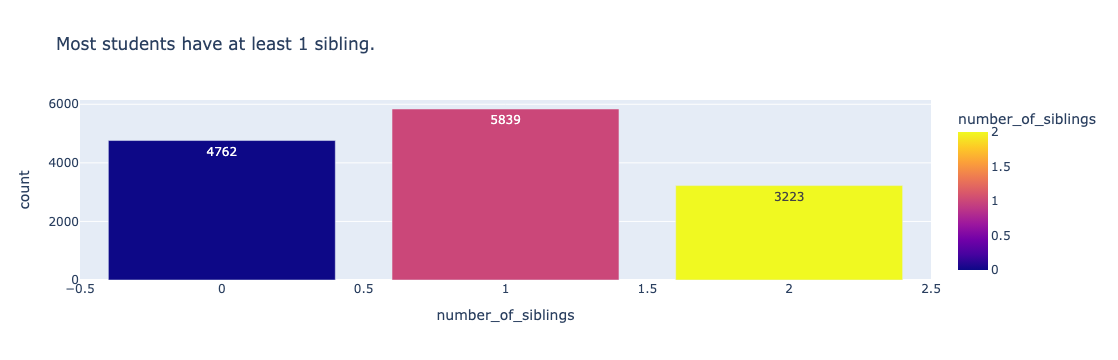

In [529]:
# How many siblings do the siblings have?
siblings = score['number_of_siblings'].value_counts().reset_index()
px.bar(siblings,x='number_of_siblings',y='count',text_auto=True,color='number_of_siblings',title='Most students have at least 1 sibling.')

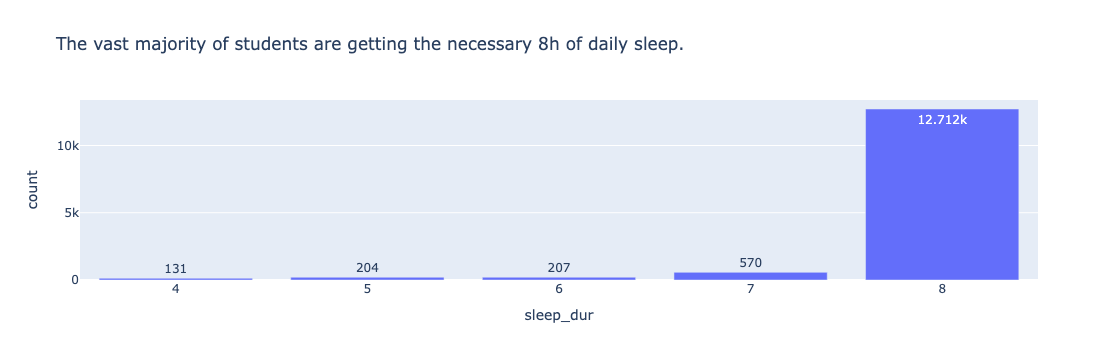

In [530]:
# How much sleep does each student get on a daily basis?
sleep = score['sleep_dur'].value_counts().reset_index()
px.bar(sleep,x='sleep_dur',y='count',text_auto=True,title='The vast majority of students are getting the necessary 8h of daily sleep.')

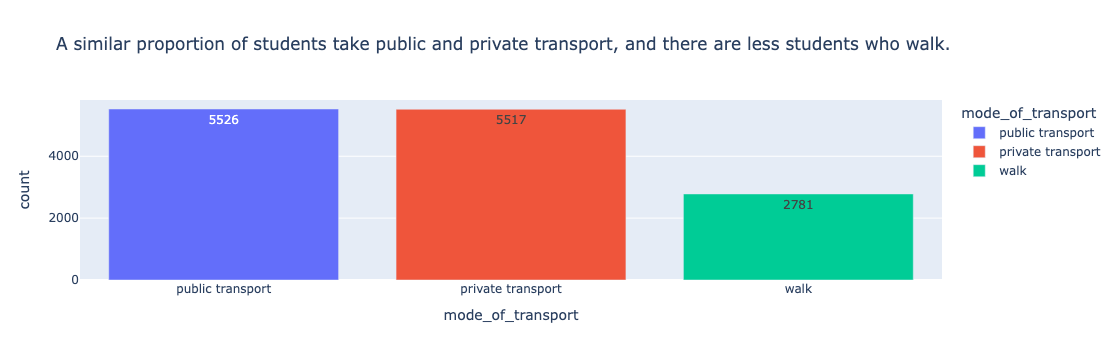

In [531]:
# How do the students travel to school?
transport = score['mode_of_transport'].value_counts().reset_index()
px.bar(transport,x='mode_of_transport',y='count',color='mode_of_transport',text_auto=True,title='A similar proportion of students take public and private transport, and there are less students who walk.')

In this section, we've gathered the following insights:

1. Males and females are roughly equally represented in the data
2. There is a roughly 60-40 proportion of auditory to visual learners
3. Most students spend between 5-14 hours studying math per week
4. There is a similar proportion of students in clubs, sports and arts CCAs
5. Most students have at least 1 sibling
6. The vast majority of students get 8 hours of sleep daily
7. Most students use public or private transport to travel to school.

### 'Failed' Analysis

At this point, I want to zero in on those who failed the exam to understand if there are attributes shared among this group.

In [535]:
failed_gender = score.groupby('failed')['gender'].value_counts().reset_index()
failed_gender['count'] = (failed_gender['count']/len(score)*100).round(2)
failed_gender['color'] = failed_gender['failed'].map({0.0: 'blue', 1.0: 'red'})
fig = px.bar(failed_gender,x='gender',y='count',color='color',text_auto=True,title='There are more females than males in the "failed" group.')
fig.update_traces(textposition="inside", insidetextanchor="middle")
fig.show()

In [536]:
# What's the breakdown of the students' learning style?
failed_learning_style = score.groupby('failed')['learning_style'].value_counts().reset_index()
failed_learning_style['count'] = (failed_learning_style['count']/len(score)*100).round(2)
failed_learning_style['color'] = failed_learning_style['failed'].map({0.0: 'blue', 1.0: 'red'})
px.bar(failed_learning_style,x='learning_style',y='count',color='color',text_auto=True,title='Those who passed and failed share similar proportions of the two learning styles.')

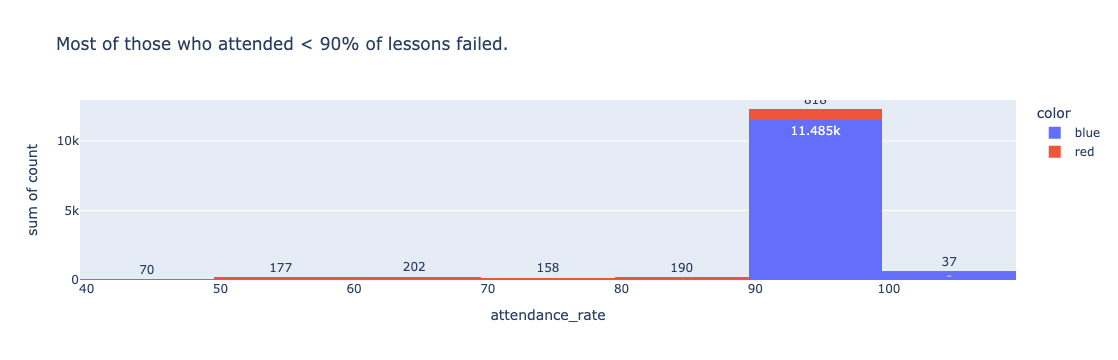

In [593]:
# How are those who failed distributed across 'attendance_rate'?
att_rate = score.groupby('failed')['attendance_rate'].value_counts().reset_index()
att_rate['color'] = att_rate['failed'].map({0:'blue',1:'red'})
px.histogram(att_rate,x='attendance_rate',y='count',color='color',text_auto=True,title='Most of those who attended < 90% of lessons failed.')

In [537]:
# What's the breakdown of the students' weekly study hours?
failed_hours = score.groupby('failed')['hours_per_week'].value_counts().reset_index()
failed_hours['color'] = failed_hours['failed'].map({0.0: 'blue', 1.0: 'red'})
fig = px.histogram(failed_hours,x='hours_per_week',y='count',color='color',text_auto=True,title='Most of those who spent only 0-4 hours studying ended up failing.')
fig.update_traces(textposition="inside", insidetextanchor="middle")

In [538]:
# How many students have been admitted by DSA?
failed_DSA = score.groupby('failed')['direct_admission'].value_counts().reset_index()
failed_DSA['color'] = failed_DSA['failed'].map({0:'blue',1:'red'})
fig = px.bar(failed_DSA,x='direct_admission',y='count',text_auto=True,color='color',title='Those who passed and failed share similar proportions of those who were and were not directly admitted.')
fig.update_traces(textposition="inside", insidetextanchor="middle")

In [539]:
# How are different CCAs represented in the data?
failed_CCA = score.groupby('failed')['CCA'].value_counts().reset_index()
failed_CCA['color'] = failed_CCA['failed'].map({0:'blue',1:'red'})
fig = px.bar(failed_CCA,x='CCA',y='count',text_auto=True,color='color',title="Each CCA type is similarly represented among those who failed compared to those who didn't.")
fig.update_traces(textposition="inside", insidetextanchor="middle")

In [540]:
# How many siblings do the siblings have?
failed_siblings = score.groupby('failed')['number_of_siblings'].value_counts().reset_index()
failed_siblings['color'] = failed_siblings['failed'].map({0:'blue',1:'red'})
px.bar(failed_siblings,x='number_of_siblings',y='count',text_auto=True,color='color',title='Almost all of those who failed have at least 1 sibling.')

In [541]:
# How much sleep does each student get on a daily basis?
failed_sleep = score.groupby('failed')['sleep_dur'].value_counts().reset_index()
failed_sleep['color'] = failed_sleep['failed'].map({0.0:'blue',1.0:'red'})
px.bar(failed_sleep,x='sleep_dur',y='count',color='color',text_auto=True,title='Most students who slept less than 7 hours ended up failing.')

In [542]:
# How do the students travel to school?
failed_transport = score.groupby('failed')['mode_of_transport'].value_counts().reset_index()
failed_transport['color'] = failed_transport['failed'].map({0.0:'blue',1.0:'red'})
fig = px.bar(failed_transport,x='mode_of_transport',y='count',color='color',text_auto=True,title="The different modes of transport are similarly represented among those who failed compared to those who didn't.")
fig.update_traces(textposition="inside", insidetextanchor="middle")

In this section, we've gathered the following insights:

1. There are more females than males among those who failed
2. Most of those who attended less than 90% of lessons ended up failing
3. Most of those who only spent 0-4 hours studying math per week ended up failing
4. Almost all who failed have at least 1 sibling
5. Most students who slept less than 7 hours ended up failing

### Inter-Variable Correlations 

#### Correlations Between Numerical Variables

In [573]:
score.head()

,gender,learning_style,attendance_rate,hours_per_week,n_male,n_female,direct_admission,CCA,tuition,number_of_siblings,sleep_time,wake_time,mode_of_transport,failed,sleep_dur
0,female,visual,91.0,10.0,14.0,2.0,yes,sports,no,0,22.0,6.0,private transport,0.0,8.0
1,female,auditory,94.0,7.0,4.0,19.0,no,sports,no,2,22.5,6.5,private transport,1.0,8.0
2,male,visual,92.0,8.0,14.0,2.0,yes,sports,no,0,22.5,6.5,private transport,0.0,8.0
4,male,auditory,95.0,7.0,24.0,3.0,no,sports,no,0,21.5,5.5,public transport,0.0,8.0
5,female,visual,96.0,11.0,9.0,12.0,no,arts,no,0,22.5,6.5,private transport,0.0,8.0


Text(0.5, 1.0, 'Correlation Heatmap of Numerical Columns')

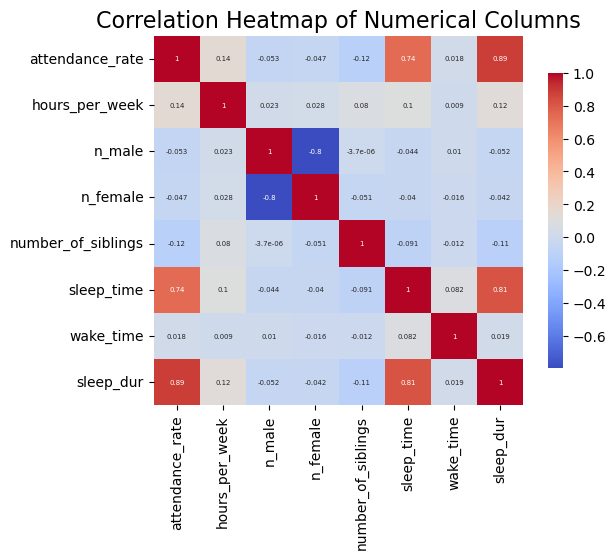

In [585]:
# Let's isolate our numerical columns first
num_cols = score.select_dtypes(include=['int64','float64']).columns
num_cols = num_cols.drop('failed')

# Creating correlation matrix table
corr_index1 = score[num_cols].corr()

# Plotting the graph
sns.heatmap(
    corr_index1,
    annot=True,
    cmap='coolwarm',
    annot_kws={"size": 5},
    square=True,
    cbar_kws={"shrink": 0.8},
    linewidths=0,
    linecolor=None
)

plt.title('Correlation Heatmap of Numerical Columns', fontsize=16)

There is a strong negative correlation between 'n_male' and 'n_female', which simply means that the higher the number of male classmates a student has, the less female students there will be in the same class and vice versa. We shall ignore this correlation.

The correlation matrix demonstrates that there is a strong positive correlation between the following pairs of numerical features:

1. 'attendance_rate' and 'sleep_time'
2. 'attendance_rate' and 'sleep_dur'

These correlations don't make intuitive sense to me, especially the first. Let me conduct more investigation. 

##### 'attendance_rate' and 'sleep_time'

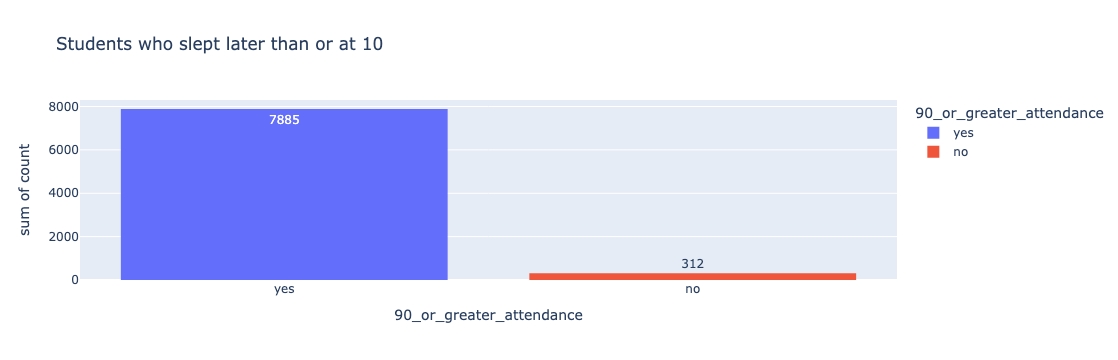

In [669]:
later_than_10 = score[score['sleep_time'] >= 22]['attendance_rate'].value_counts().reset_index()
later_than_10['90_or_greater_attendance'] = later_than_10['attendance_rate'].map(lambda x: 'yes' if x >= 90 else 'no')
px.histogram(later_than_10,x='90_or_greater_attendance',y='count',color='90_or_greater_attendance',text_auto=True,title='Students who slept later than or at 10',nbins=5)

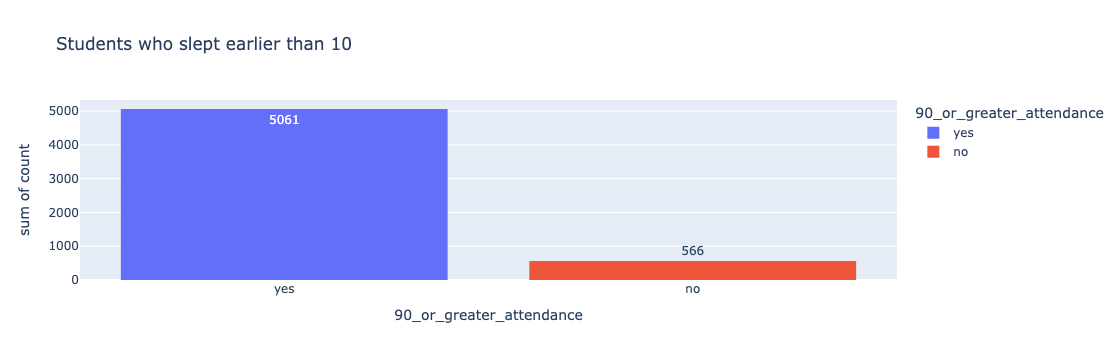

In [671]:
earlier_than_10 = score[score['sleep_time'] < 22]['attendance_rate'].value_counts().reset_index()
earlier_than_10['90_or_greater_attendance'] = earlier_than_10['attendance_rate'].map(lambda x: 'yes' if x >= 90 else 'no')
px.histogram(earlier_than_10,x='90_or_greater_attendance',y='count',color='90_or_greater_attendance',text_auto=True,title='Students who slept earlier than 10')

This correlation did not make intuitive sense to me as I would think that a student is more likely to be present in school if they sleep earlier, since this means they are more likely to wake up early enough to be on time or present for school.

**However, the data shows us that there are more students who slept earlier than 10PM with an attendance rate < 90% (total: 566) than students who slept at 10PM or later with an attendance rate of < 90% (total: 312).**

This may be because students who sleep at or later than 10PM are facing a higher degree of expectations. This either means heavy commitment to their CCA, more after-school tuition (which reflects an expectation by parents to perform well in exams).

These high expectations also mean that these students have less incentive to be less involved in school activities despite sleeping later.

##### 'attendance_rate' and 'sleep_dur'

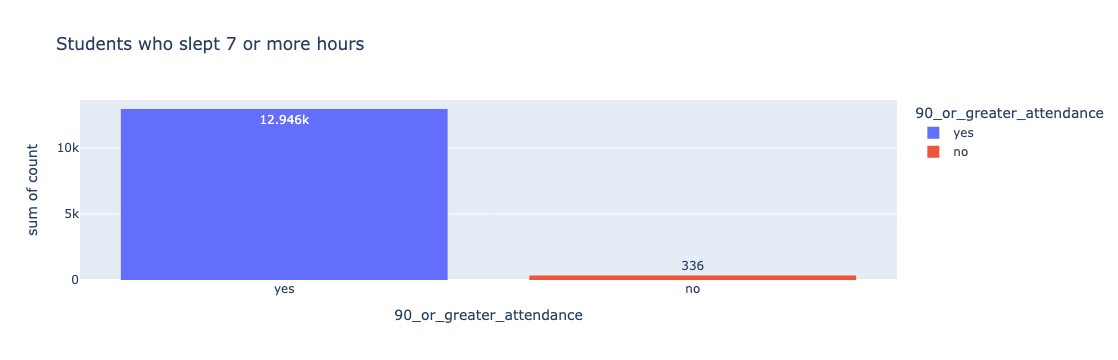

In [673]:
seven_or_more = score[score['sleep_dur'] >= 7]['attendance_rate'].value_counts().reset_index()
seven_or_more['90_or_greater_attendance'] = seven_or_more['attendance_rate'].map(lambda x: 'yes' if x >= 90 else 'no')
px.histogram(seven_or_more,x='90_or_greater_attendance',y='count',color='90_or_greater_attendance',text_auto=True,title='Students who slept 7 or more hours',nbins=5)

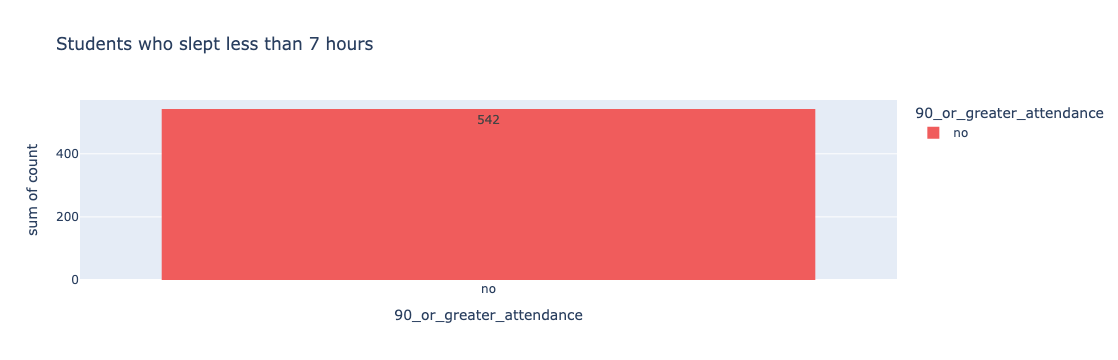

In [675]:
less_than_seven = score[score['sleep_dur'] < 7]['attendance_rate'].value_counts().reset_index()
less_than_seven['90_or_greater_attendance'] = less_than_seven['attendance_rate'].map(lambda x: 'yes' if x >= 90 else 'no')
px.histogram(less_than_seven,x='90_or_greater_attendance',y='count',color='90_or_greater_attendance',color_discrete_map={'no':'#f05c5c'},text_auto=True,title='Students who slept less than 7 hours',nbins=5)

**Virtually all students who slept < 7 hours had attendance rates of < 90% (total: 542). This number is larger than the total number of students who slept >= 7 hours with attendance rates of < 90% (total: 336).**

This tells us that even though more students with an attendance rate of >= 90% were sleeping at 10PM or later, these students were also getting enough rest (at least 7 hours)!

##### Deciding which variable to drop for modelling

In [711]:
# Correlation matrix including the target
num_cols = score.select_dtypes(include=['int64','float64']).columns
corr_index2 = score[num_cols]
corr_index2 = corr_index1.corr()

# Individual Correlations to the target
print(corr_index2['failed'].sort_values(ascending=False))

failed                1.000000
number_of_siblings    0.406986
n_female              0.118181
n_male                0.079902
wake_time            -0.024059
hours_per_week       -0.467468
sleep_time           -0.866819
sleep_dur            -0.895957
attendance_rate      -0.910479
Name: failed, dtype: float64


As we have seen, 'attendance_rate', 'sleep_dur' and 'sleep_time' all have strong negative relationships with the target 'failed' (the higher the values under any of these 3 variables, the less likely the student will be marked as 'failed').

Among them, the variable with the weakest relationship with the target is 'sleep_time'. I would not want to drop 'sleep_dur' because sleep appears to be an important influence on whether a student passes. The same can be said about 'attendance_rate'. As a result, I will keep 'sleep_dur' and 'attendance_rate'.

In [717]:
score = score.drop('sleep_time',axis=1)
score.head()

,gender,learning_style,attendance_rate,hours_per_week,n_male,n_female,direct_admission,CCA,tuition,number_of_siblings,wake_time,mode_of_transport,failed,sleep_dur
0,female,visual,91.0,10.0,14.0,2.0,yes,sports,no,0,6.0,private transport,0.0,8.0
1,female,auditory,94.0,7.0,4.0,19.0,no,sports,no,2,6.5,private transport,1.0,8.0
2,male,visual,92.0,8.0,14.0,2.0,yes,sports,no,0,6.5,private transport,0.0,8.0
4,male,auditory,95.0,7.0,24.0,3.0,no,sports,no,0,5.5,public transport,0.0,8.0
5,female,visual,96.0,11.0,9.0,12.0,no,arts,no,0,6.5,private transport,0.0,8.0


#### Correlations Between Categorical Variables

Text(0.5, 1.0, 'Correlation Heatmap of Categorical Columns')

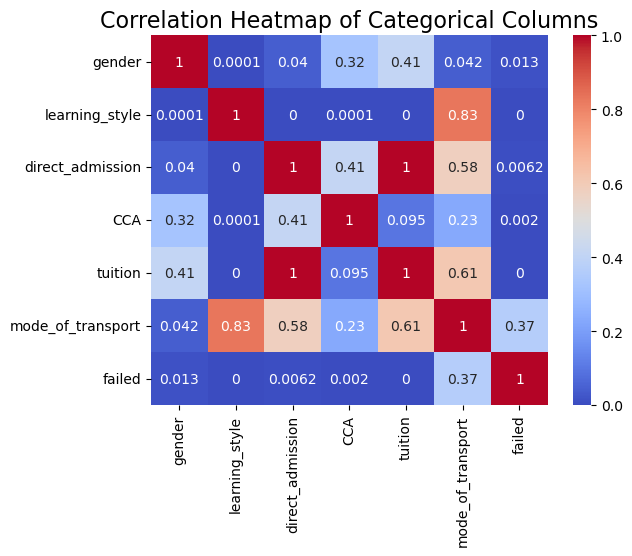

In [733]:
# Let's isolate our categorical columns first (I will include 'failed' as it is ultimately still a categorical variable)
cat_cols = ['gender','learning_style','direct_admission','CCA','tuition','mode_of_transport','failed']

# Now let's create a square-shaped dataframe with cat_cols serving as both the rows and columns
p_value_matrix = pd.DataFrame(index=cat_cols,columns=cat_cols)

# Let's fill in each cell in the matrix with the p-values of the chi-squared test of independence between each pair of categorical columns
for col_a in cat_cols:
    for col_b in cat_cols:
        if col_a == col_b:
            p_value_matrix.loc[col_a,col_b] = 1
        else:
            contingency_table = pd.crosstab(score[col_a],score[col_b])
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            p_value_matrix.loc[col_a,col_b] = round(p,4)

p_value_matrix = p_value_matrix.astype(float)

sns.heatmap(p_value_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Categorical Columns', fontsize=16)

In [735]:
print(p_value_matrix['failed'].sort_values(ascending=False))

failed               1.0000
mode_of_transport    0.3669
gender               0.0135
direct_admission     0.0062
CCA                  0.0020
learning_style       0.0000
tuition              0.0000
Name: failed, dtype: float64


The p-value matrix shows us that a number of variables have high p-values in the chi-squared test of independence with 'mode_of_transport'. In addition, 'mode_of_transport' also has the highest p-value when the chi-squared test of independence is done between the target and all other categorical variables. These observations suggest that 'mode_of_transport' may not be helpful for modelling as it is unrelated to both the other variables and the target itself. 

As a result, I will drop 'mode_of_transport'

In [742]:
score = score.drop('mode_of_transport',axis=1)
score.head()

,gender,learning_style,attendance_rate,hours_per_week,n_male,n_female,direct_admission,CCA,tuition,number_of_siblings,wake_time,failed,sleep_dur
0,female,visual,91.0,10.0,14.0,2.0,yes,sports,no,0,6.0,0.0,8.0
1,female,auditory,94.0,7.0,4.0,19.0,no,sports,no,2,6.5,1.0,8.0
2,male,visual,92.0,8.0,14.0,2.0,yes,sports,no,0,6.5,0.0,8.0
4,male,auditory,95.0,7.0,24.0,3.0,no,sports,no,0,5.5,0.0,8.0
5,female,visual,96.0,11.0,9.0,12.0,no,arts,no,0,6.5,0.0,8.0


#### Final Drop: Dropping 'wake_time'

In [763]:
score['wake_time'].value_counts()

wake_time
5.0    2807
7.0    2781
6.0    2773
6.5    2744
5.5    2719
Name: count, dtype: int64

Because 'sleep_time' has been dropped, I wondered about how useful 'wake_time' will be. 

'sleep_time' was potentially useful as I suspected there might have been a correlation between 'sleep_time' and 'failed'. Logically, if the student sleeps later, they may not be able to either arrive in school on time or pay attention in school well enough to pass. However, due to reasons we discovered earlier, we dropped 'sleep_time'.

On the other hand, 'wake_time' does not seem to carry much potential in influencing 'failed' because 'wake_time' does not encompass a wide range of values (the range encompasses a 2h window altogether). Furthermore, the Pearson correlation between 'wake_time' and 'failed' was very close to 0 (-0.024059), suggesting that there is close to no linear relationship between 'wake_time' and 'failed'. 

To keep the model simple, I shall drop 'wake_time' as I intend to use a linear regression model for the pipeline. The reason why I want to use a linear regression model is because I am prioritising interpretability for this project.

In [769]:
score = score.drop('wake_time',axis=1)
score.head()

,gender,learning_style,attendance_rate,hours_per_week,n_male,n_female,direct_admission,CCA,tuition,number_of_siblings,failed,sleep_dur
0,female,visual,91.0,10.0,14.0,2.0,yes,sports,no,0,0.0,8.0
1,female,auditory,94.0,7.0,4.0,19.0,no,sports,no,2,1.0,8.0
2,male,visual,92.0,8.0,14.0,2.0,yes,sports,no,0,0.0,8.0
4,male,auditory,95.0,7.0,24.0,3.0,no,sports,no,0,0.0,8.0
5,female,visual,96.0,11.0,9.0,12.0,no,arts,no,0,0.0,8.0


In [792]:
# Time to save my cleaned/engineered dataframe
score.to_csv('score_cleaned.csv',index=False)

## Part 4: EDA Conclusions & Summary of Process

### EDA Conclusions

My EDA has uncovered the following findings.

**General Observations About the Dataset**

1. Males and females are roughly equally represented in the data
2. There is a roughly 60-40 proportion of auditory to visual learners
3. Most students spend between 5-14 hours studying math per week
4. There is a similar proportion of students in clubs, sports and arts CCAs
5. Most students have at least 1 sibling
6. The vast majority of students get 8 hours of sleep daily
7. Most students use public or private transport to travel to school.

**Most Influential Features on 'Failed'**

I have determined that the variables *'gender', 'attendance_rate', 'hours_per_week', 'number_of_siblings', 'sleep_dur'* are influential on whether a student passed or failed. This is because:

1. There are more females than males among those who failed
2. Most of those who attended less than 90% of lessons ended up failing
3. Most of those who only spent 0-4 hours studying math per week ended up failing
4. Almost all who failed have at least 1 sibling
5. Most students who slept less than 7 hours ended up failing

**Features Found to be Less Helpful for Predicting 'Failed'**

1. **Numerical**: Because 'sleep_time', 'sleep_dur' and 'attendance_rate' were all strongly correlated to each other, I decided to drop 'sleep_time' after judging that it was least influential on 'failed' among the three when checking the correlations between them and 'failed'.
2. **Categorical**: Because the p-values from the chi-squared test of independence between 'mode_of_transport' and other categorical variables as well as with 'failed' was high, I dropped 'mode_of_transport' as the high p-values suggest that it is not influential on the other categorical or on 'failed'. 

### Summary of Processes

**Before Cleaning**
The dataset had the following columns:

1. index
2. student_id
3. number_of_siblings
4. direct_admission
5. CCA
6. learning_style
7. tuition
8. n_male
9. n_female
10. gender
11. age
12. hours_per_week
13. attendance_rate
14. sleep_time
15. wake_time
16. mode_of_transport
17. bag_color
18. final_test

**Data Cleaning**
The following steps were taken to clean the data:

*Duplicates*
Based on student_id, there were 900 rows of duplicates. I dropped these rows.

*Null Values*

final_test: As only 3.09% of rows had null values under this column, I decided to drop the rows where 'final_test' was null, so I can have a dataset with non-null 'final_test' values (I needed this column to create the new y-variable, 'failed')

attendance_rate: As only 4.89% of rows had null values under this column, I decided to drop the rows where 'attendance_rate' was null, so I can have a dataset with non-null 'attendance_rate' values

CCA: As 24% of rows had null values under this column, with no other columns able to provide me with clues on how to impute them, I decided to use random foresets to impute the missing data in a way that doesn't disrupt the existing composition of the CCA column.

**Feature Engineering**

*Creating 'failed' based on 'final_test'*

I created a new column, 'failed', based on whether the student attained at least 50 for 'final_test'. 'failed' is now the new y-variable. 'final_test' was dropped afterward.

*Dropping Obviously Less Useful Columns*

I dropped the following columns as they were most obviously not useful to predicting 'failed':
1. index
2. age
3. bag_color
4. student_id (I did this later, but it would ultimately not be useful for modelling)

*Re-engineering 'sleep_time' and 'wake_time' to float form, creating 'sleep_dur' column*

I converted 'sleep_time' and 'wake_time' to float form as they were in string format. From these conversions, I created 'sleep_dur' to capture the duration for which each student slept daily.

'sleep_time' and 'wake_time' were then dropped.

*Dropping Variables After Inter-Variable Correlation Analysis*

1. Numerical Variables:

**'sleep_time'** was dropped as it was highly correlated with 'sleep_dur' and 'attendance_rate'. 'sleep_time' was the least influential on 'failed' based on the Pearson correlation between it and other numerical variables. 

**'wake_time'** was then dropped as 'wake_time' does not capture a wide range of values, and the Pearson correlation between 'wake_time' and 'failed' suggests that there is close to no linear relationship between 'wake_time' and 'failed'.

2. Categorical Variables: **'mode_of_transport'** was dropped as it demonstrated a strong independent relationship with other categorical variables and 'failed'.

**Total Dropped (Without Being Used for Engineering)**

1. index
2. age
3. bag_color
4. student_id
5. mode of transport

**Columns Used for Engineering (Before Being Dropped)**

1. final_test
2. sleep_time
3. wake_time

**Final Dataset Features**
1. gender
2. learning_style
3. attendance_rate
4. hours_per_week
5. n_male
6. n_female
7. direct_admission
8. CCA
9. tuition
10. number_of_siblings
11. failed
12. sleep_dur

## Part 5: Testing My Pipeline

In [5]:
# Finally, let me try to run my pipeline to verify my model's accuracy
%run main.py

{'accuracy': 0.9432188065099457, 'precision': 0.8559670781893004, 'recall': 0.6303030303030303, 'confusion_matrix': array([[2400,   35],
       [ 122,  208]])}


My modelling pipeline has returned the following statistics:

- Accuracy (How accurate the model's predictions is overall) = Model is correct 94.3% of the time
- Precision (Out of all predicted failures, which were actually failures?) = ~86% predicted failures ended up being failures
- Recall (Out of all actual failures, which were predicted correctly?) = Out of all actual failures, the model only caught ~63%